# Сначала, вспомним некоторые ключевые моменты из предыдущих занятий

Алгоритм **Прейсущественный Актёр-Критик** очень сильно похож на алгоритм **REINFORCE**, и в чём-то также похож на алгоритм **Q-обучение**. По этому, нам нужно сначала вспомнить некоторые ключевые особенности этих алгоритмов.

## Алгоритм Q-обучения

* Фактический решает задачу регрессии, предсказывая ценности Q(s, a) для каждого возможного действия по заданному состоянию.

* "Нужное" действие считается тем, которое приносит максимальную ценность Q(s, a).

* Q(s, a) = γ\*Q(s', a') + γ<sup>2</sup>\*Q(s'', a'') + γ<sup>3</sup>\*Q(s''', a''') ... (бесконечный ряд).

* Алгоритм Q-обучения обучается на мини-пакетах данных, желательно которые сэмплируются из буфера памяти рандомно. В каждом сэмпле данных содержутся состояния на момент n и n+1 - предсказывая ценность на оба состояния мы можем предсказать ценность выше-написанного уравнения.

##Алгоритм REINFORCE

* Фактический решает задачу классификации (функция ошибки использует категориальную кросс-энтропию и выходной слой использует активационную функцию софтмакс). Точнее, значение ошибки = `categorical_crossentropy(chosen_actions, predicted_probabilities) * preprocessed_rewards`.

* Вместо точного предсказания определённого действия, этот алгоритм предсказывает вероятности принятия того или инного действия (в большинстве его работоспособных реализаций). Если предсказывать действия через `argmax()`, этот алгоритм не будет исследовать среду и сразу же будет переобучаться.

* Этот алгоритм должен сразу обучаться на всём эпизоде одновременно, т.к. это политический метод обучения (on policy reinforcement learning). Причём, награды полученые от среды нужно сначала обработать определённой функцией, которая распростроняет награды обратно во времени, чтобы получить похожий эффект на уравнения Q(s, a).

* При получении положительной награды за выбранное действие, вероятность выбора того же действия в похожем состоянии увеличивается (и вероятность выбора всех остальных действий снижается). При получении отрициательной награды, вероятность выбора того же действия в похожем состоянии снижается (а всех остальных, увеличивается). **Именно это является ключевым недостатком алгоритма REINFORCE - он не сможет обучиться если все награды положительные или все награды отрициательные. Более того, если есть две награды +10 и +100 (за два разных действия), этот алгоритм  может случайно выбрать действие с наградой +10 несколько раз и вероятность повторного выбора этого действия станет практический 99.9%, после чего выбора действия с наградой +100 станет таким редким, что алгоритм никогда не научится выбирать это действие.**

[**Вилуализация выше-описанной проблемы алгоритма REINFORCE**](https://towardsdatascience.com/an-intuitive-explanation-of-policy-gradient-part-1-reinforce-aa4392cbfd3c) - из-за того, что действие с наименьшей наградой изначально имеет более высокую вероятность выбора, алгоритм не видит более высокие награды достаточно часто, чтобы их эксплуатировать.

<sub> График создан автором Adrien Lucas Ecoffet на его статье по выше-указанной ссылке.</sub>

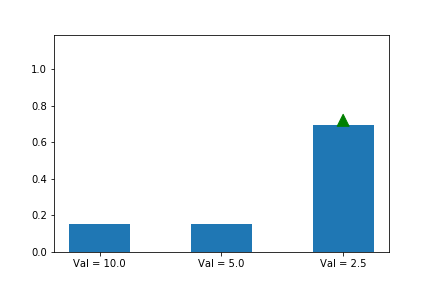

#Преймущественный Актёр-Критик

* Это алгоритм который соеденяет методы значений (value-based methods) и поличитеские методы (policy-based methods) в один алгоритм. Можно сказать, что это в чём-то "смесь" Q-обучения и алгоритма REINFORCE.

* * Алгоритм состоит из двух частей: актёра (выполняет похожие функции на алгоритм REINFORCE) и критика (который предсказывает значение обработанной награды, и этим выполняет задачу регрессии - т.е. похож на Q-обучение).

* * Идея заключается в том, что только актёр контролирует агента, тем временем как критик помогает актёру обучаться лучше и стабильнее, чем это происходит в алгоримте REINFORCE. Часто приводиться аналог, где критик действует как 'учитель', который сообщает актёру (ученику) если он действует плохо или хорошо.

_______

* Актёр и критик могут существовать в отдельных нейронных сетях, либо в рамках одной сети с двумя выходами (мы рассмотрим оба варианта в практических частях). В любом случае, они оба состоят из обучаемых параметров.

* * Это значит, что для обучения актёра, сначала нужно обучить критика. На практике, актёр и критик обучаются на данных одновременно, но критик всегда первый успешно 'обучается' выполнять свою задачу. **Очень часто, критику дается более высокий шаг обучения, чем актёру, чтобы тот мог быстрее научиться, и актёр тоже мог начать обучаться.** Однако, ставить разные шаги обучения не обязательно, и в многом зависит от задачи.

* * Критик обучается предсказывать ценности состояний, которые в данном случае определяются как обработанные награды V(s). В алгоритме REINFORCE, значение категориальной кросс-энтроаии умножается на Q(s, a), тем временем как в актёр-критике, **категориальная кросс-энтропия умножается на значение преймущества A(s, a)**. Из предыдущего занятия, мы помним что A(s, a) = Q(s, a) - V(s, a). 

Актёр обучается также, как в алгоритме REINFORCE, за исключением того что **вместо значение обработанной награды V(s) он ориентируется на преймущества A(s, a)**. По этому алгоритм называется *преймущественный актёр-критик*.

Ниже представленный псевдо-код описывает все основные различия алгоритма актёр-критика от REINFORCE.

In [ ]:
# Инными словами, нужно заменить этот примерный код из алгоритма REINFORCE:

preprocessed_rewards = preprocess_rewards(rewards) #Обрабатываем награды полученые от среды этой гипотетической функцией
model.train_on_batch(states, actions, sample_weights = preprocessed_rewards) #Обучаем модель на обработанных наградах

In [ ]:
# На следующий код:

preprocessed_rewards = preprocess_rewards(rewards) #Обрабатываем награды полученые от среды этой гипотетической функцией
values = critic.predict(states)                    #Предсказываем значения V(s) через критика
advantages = preprocessed_rewards - values         #Считаем значения A(s, a)

actor.train_on_batch(states, actions, sample_weights = advantages) #Обучаем актёра на значений преймущества

critic.train_on_batch(states, preprocessed_rewards) #Обучаем критика предсказывать обработанные значения награды

В большинстве случаев, алгоритм актёр-критик намного способнее, чем алгоритм REINFORCE, разве что для очень простых задач где REINFORCE иногда работает лучше. Но стоит также отметить, что работа алгоритма актёр-критика может быть очень чувствительна к значениям гиперпараметров.

Также, в этом занятии мы рассмотрим разновидность преймущественного актёра критика, который известен как **асинхронный преймущественный актёр-критик.** Для этого алгоритма есть отдельный теоретический блок, который содержиться в соответствующем ноутбуке.